In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Bear Phase LSTM Time Series'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Bear Phase Stock Data

bear phase data\0_acc_data.csv
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-07-29    49.000000  49.438690 -80.861264  113567600.0     2.0
2013-07-30    48.910000  49.357353 -83.014377  111851600.0     2.0
2013-07-31    49.790001  49.423914 -61.961722  113019000.0     2.0
2013-08-01    49.869999  49.492543 -51.169618  113978800.0     2.0
2013-08-02    51.459999  49.795228 -19.306991  115490000.0     0.0


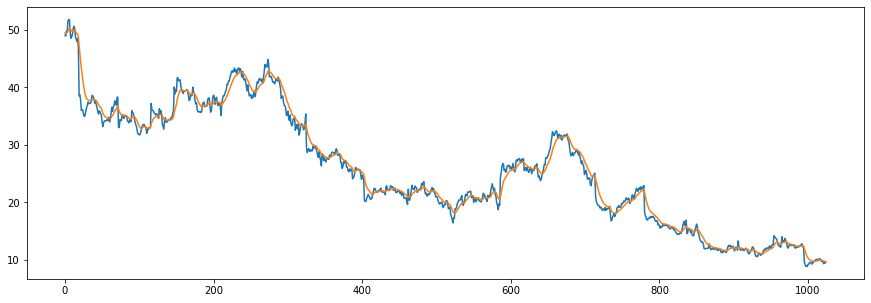

bear phase data\1_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


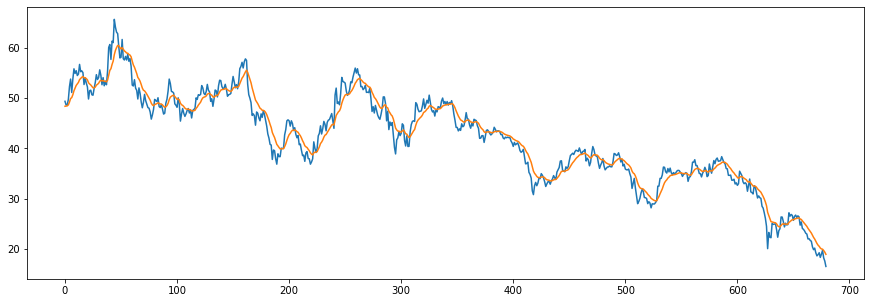

bear phase data\2_acc_data.csv
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2001-04-16    29.000000  28.506905 -34.482761 -99375452.0     2.0
2001-04-17    29.180000  28.610458 -27.586194 -95843852.0     2.0
2001-04-18    28.879999  28.651926 -39.080497 -99108352.0     0.0
2001-04-19    30.709999  28.968553 -17.191311 -87511052.0     2.0
2001-04-20    30.299999  29.173391 -27.118670 -94318852.0     2.0


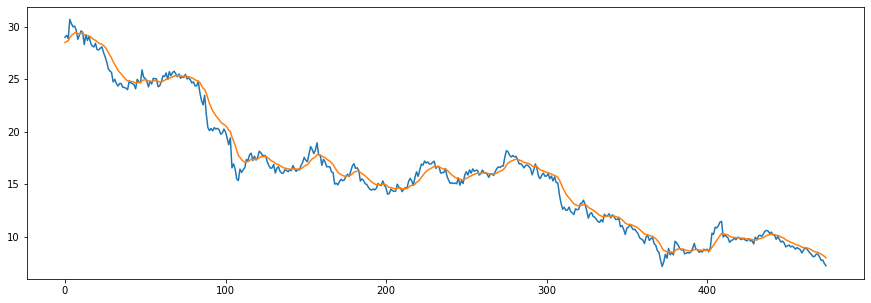

bear phase data\3_acc_data.csv
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2011-01-03    36.860001  35.273652  -3.166198  661708900.0     2.0
2011-01-04    37.060001  35.548475 -19.542585  686583800.0     2.0
2011-01-05    37.900002  35.910248  -2.078970  718947200.0     2.0
2011-01-06    38.070000  36.242518  -4.500969  741451100.0     2.0
2011-01-07    38.900002  36.651361  -9.220953  780008000.0     0.0


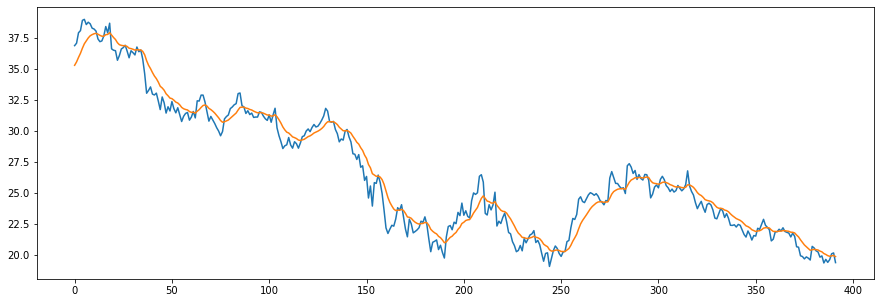

bear phase data\4_acc_data.csv
            previous_1d    EMA_12   willr_14         OBV_7  labels
Date                                                              
2018-01-22         7.19  6.771425  -1.136336  3.248229e+09     2.0
2018-01-23         7.09  6.820437 -14.666621  2.718594e+09     2.0
2018-01-24         7.33  6.898831  -8.333325  3.443507e+09     2.0
2018-01-25         7.28  6.957472 -13.541628  2.874295e+09     2.0
2018-01-26         7.06  6.973246 -36.458322  2.394853e+09     2.0


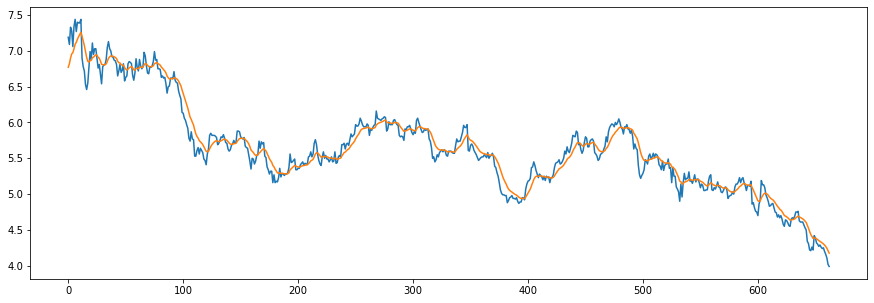

bear phase data\5_acc_data.csv
            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2018-01-23    36.180000  35.813713 -13.991774 -1195100.0     0.0
2018-01-24    36.470001  35.914681  -2.403807  -818600.0     2.0
2018-01-25    36.330002  35.978576 -13.013613 -1233200.0     2.0
2018-01-26    35.900002  35.966488 -54.867110 -1638100.0     2.0
2018-01-29    36.209999  36.003951 -29.245375 -1229100.0     2.0


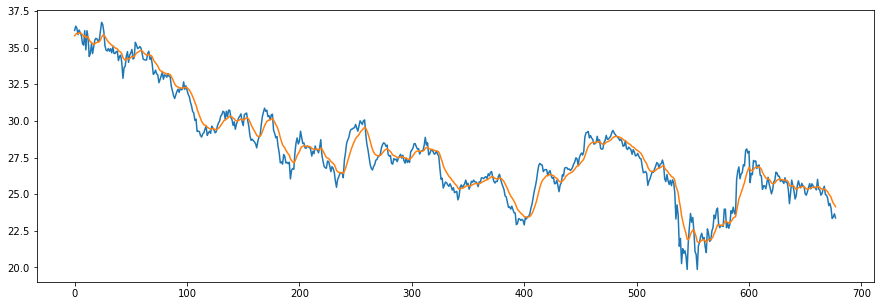

bear phase data\6_acc_data.csv
            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2013-11-18    41.169998  40.276379  -1.421923  6585600.0     2.0
2013-11-19    41.230000  40.423090 -14.056307  6808000.0     2.0
2013-11-20    40.970001  40.507230 -24.498000  6523100.0     2.0
2013-11-21    41.189999  40.612271 -15.662769  6840300.0     2.0
2013-11-22    42.430000  40.891922  -0.595252  7413300.0     0.0


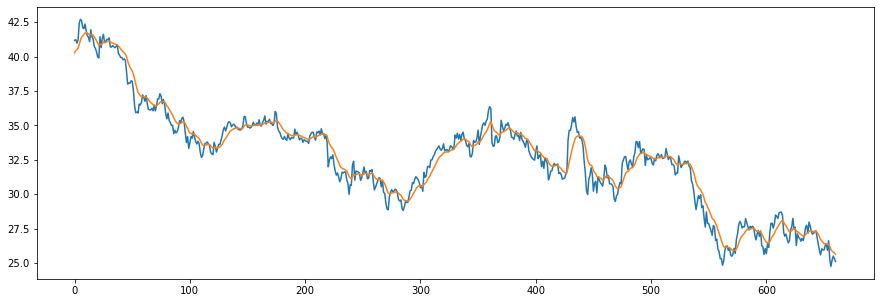

In [5]:
labels = []
sequential = []

for filepath in glob.iglob('bear phase data/*_acc_data.csv'):
    print(filepath)
    seed = 10
    df = pd.read_csv(filepath)
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [6]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(4476, 15, 4)

In [7]:
y = labels
y = np.array(y)
y.shape

(4476,)

In [8]:
from collections import Counter

Counter(y)

Counter({2.0: 4068, 1.0: 208, 0.0: 200})

In [9]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [10]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [11]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [12]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [14]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
28/28 [==============================] - 1s 32ms/step - loss: 0.2895 - accuracy: 0.4986 - mse: 0.4641 - weighted_accuracy: 0.3078 - weighted_mse: 0.5343 - val_loss: 0.2994 - val_accuracy: 0.0469 - val_mse: 0.3541 - val_weighted_accuracy: 0.0469 - val_weighted_mse: 0.3541
Epoch 2/200
28/28 [==============================] - 0s 7ms/step - loss: 0.2121 - accuracy: 0.3321 - mse: 0.7874 - weighted_accuracy: 0.4397 - weighted_mse: 0.7607 - val_loss: 0.2914 - val_accuracy: 0.0469 - val_mse: 0.3796 - val_weighted_accuracy: 0.0469 - val_weighted_mse: 0.3796
Epoch 3/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1906 - accuracy: 0.2472 - mse: 1.0259 - weighted_accuracy: 0.4679 - weighted_mse: 0.9737 - val_loss: 0.2805 - val_accuracy: 0.0469 - val_mse: 0.4129 - val_weighted_accuracy: 0.0469 - val_weighted_mse: 0.4129
Epoch 4/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1828 - accuracy: 0.2687 - mse: 1.1536 - weighted_accuracy: 0.4897 - weighte

Epoch 30/200
28/28 [==============================] - 0s 6ms/step - loss: 0.1375 - accuracy: 0.4405 - mse: 1.5903 - weighted_accuracy: 0.7213 - weighted_mse: 1.5298 - val_loss: 0.1789 - val_accuracy: 0.4364 - val_mse: 1.5565 - val_weighted_accuracy: 0.4364 - val_weighted_mse: 1.5565
Epoch 31/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1370 - accuracy: 0.3913 - mse: 1.6148 - weighted_accuracy: 0.7244 - weighted_mse: 1.5264 - val_loss: 0.1815 - val_accuracy: 0.4286 - val_mse: 1.5655 - val_weighted_accuracy: 0.4286 - val_weighted_mse: 1.5655
Epoch 32/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1361 - accuracy: 0.4352 - mse: 1.6260 - weighted_accuracy: 0.7191 - weighted_mse: 1.5520 - val_loss: 0.1814 - val_accuracy: 0.4565 - val_mse: 1.5234 - val_weighted_accuracy: 0.4565 - val_weighted_mse: 1.5234
Epoch 33/200
28/28 [==============================] - 0s 6ms/step - loss: 0.1351 - accuracy: 0.4095 - mse: 1.6468 - weighted_accuracy: 0.7273 - weig

Epoch 59/200
28/28 [==============================] - 0s 6ms/step - loss: 0.1117 - accuracy: 0.5777 - mse: 1.9949 - weighted_accuracy: 0.8161 - weighted_mse: 1.9617 - val_loss: 0.1814 - val_accuracy: 0.4888 - val_mse: 2.1222 - val_weighted_accuracy: 0.4888 - val_weighted_mse: 2.1222
Epoch 60/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1111 - accuracy: 0.5782 - mse: 2.0420 - weighted_accuracy: 0.8048 - weighted_mse: 2.0006 - val_loss: 0.1862 - val_accuracy: 0.4688 - val_mse: 2.1279 - val_weighted_accuracy: 0.4688 - val_weighted_mse: 2.1279
Epoch 61/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1109 - accuracy: 0.6047 - mse: 2.0461 - weighted_accuracy: 0.8202 - weighted_mse: 2.0139 - val_loss: 0.1903 - val_accuracy: 0.4710 - val_mse: 2.2280 - val_weighted_accuracy: 0.4710 - val_weighted_mse: 2.2280
Epoch 62/200
28/28 [==============================] - 0s 7ms/step - loss: 0.1100 - accuracy: 0.5880 - mse: 2.0444 - weighted_accuracy: 0.8256 - weig

Epoch 88/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0904 - accuracy: 0.7003 - mse: 2.6598 - weighted_accuracy: 0.8667 - weighted_mse: 2.6722 - val_loss: 0.1926 - val_accuracy: 0.5346 - val_mse: 2.7466 - val_weighted_accuracy: 0.5346 - val_weighted_mse: 2.7466
Epoch 89/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0859 - accuracy: 0.7154 - mse: 2.6508 - weighted_accuracy: 0.8705 - weighted_mse: 2.7084 - val_loss: 0.1669 - val_accuracy: 0.6306 - val_mse: 2.9519 - val_weighted_accuracy: 0.6306 - val_weighted_mse: 2.9519
Epoch 90/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0846 - accuracy: 0.7226 - mse: 2.7023 - weighted_accuracy: 0.8789 - weighted_mse: 2.7708 - val_loss: 0.1780 - val_accuracy: 0.5848 - val_mse: 2.8716 - val_weighted_accuracy: 0.5848 - val_weighted_mse: 2.8716
Epoch 91/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0848 - accuracy: 0.7263 - mse: 2.7139 - weighted_accuracy: 0.8821 - weig

Epoch 117/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0635 - accuracy: 0.8008 - mse: 3.7138 - weighted_accuracy: 0.9231 - weighted_mse: 3.7733 - val_loss: 0.1689 - val_accuracy: 0.6942 - val_mse: 3.9301 - val_weighted_accuracy: 0.6942 - val_weighted_mse: 3.9301
Epoch 118/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0635 - accuracy: 0.8170 - mse: 3.8472 - weighted_accuracy: 0.9309 - weighted_mse: 3.8866 - val_loss: 0.1902 - val_accuracy: 0.6395 - val_mse: 4.3535 - val_weighted_accuracy: 0.6395 - val_weighted_mse: 4.3535
Epoch 119/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0640 - accuracy: 0.8120 - mse: 3.8116 - weighted_accuracy: 0.9174 - weighted_mse: 3.8476 - val_loss: 0.1889 - val_accuracy: 0.6395 - val_mse: 3.9593 - val_weighted_accuracy: 0.6395 - val_weighted_mse: 3.9593
Epoch 120/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0644 - accuracy: 0.8003 - mse: 3.8198 - weighted_accuracy: 0.9152 - 

Epoch 146/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0477 - accuracy: 0.8656 - mse: 5.3258 - weighted_accuracy: 0.9370 - weighted_mse: 5.2151 - val_loss: 0.2211 - val_accuracy: 0.6496 - val_mse: 5.5774 - val_weighted_accuracy: 0.6496 - val_weighted_mse: 5.5774
Epoch 147/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0499 - accuracy: 0.8628 - mse: 5.3098 - weighted_accuracy: 0.9359 - weighted_mse: 5.1900 - val_loss: 0.2400 - val_accuracy: 0.6239 - val_mse: 5.1702 - val_weighted_accuracy: 0.6239 - val_weighted_mse: 5.1702
Epoch 148/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0459 - accuracy: 0.8732 - mse: 5.3797 - weighted_accuracy: 0.9497 - weighted_mse: 5.2244 - val_loss: 0.2002 - val_accuracy: 0.6964 - val_mse: 5.6988 - val_weighted_accuracy: 0.6964 - val_weighted_mse: 5.6988
Epoch 149/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0460 - accuracy: 0.8763 - mse: 5.4864 - weighted_accuracy: 0.9489 - 

Epoch 175/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0385 - accuracy: 0.8953 - mse: 7.1938 - weighted_accuracy: 0.9559 - weighted_mse: 6.6885 - val_loss: 0.2240 - val_accuracy: 0.7199 - val_mse: 7.3196 - val_weighted_accuracy: 0.7199 - val_weighted_mse: 7.3196
Epoch 176/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0369 - accuracy: 0.9050 - mse: 7.1602 - weighted_accuracy: 0.9612 - weighted_mse: 6.6949 - val_loss: 0.2192 - val_accuracy: 0.7712 - val_mse: 8.1525 - val_weighted_accuracy: 0.7712 - val_weighted_mse: 8.1525
Epoch 177/200
28/28 [==============================] - 0s 6ms/step - loss: 0.0353 - accuracy: 0.9109 - mse: 7.2014 - weighted_accuracy: 0.9615 - weighted_mse: 6.7467 - val_loss: 0.2512 - val_accuracy: 0.6942 - val_mse: 7.1683 - val_weighted_accuracy: 0.6942 - val_weighted_mse: 7.1683
Epoch 178/200
28/28 [==============================] - 0s 7ms/step - loss: 0.0342 - accuracy: 0.9067 - mse: 7.2012 - weighted_accuracy: 0.9638 - 

In [15]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2510733902454376
Test accuracy: 0.7879464030265808


In [16]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-4.3930163  -0.8114047   0.26703775]
 [-5.060005   -1.3535805   0.17788929]
 [-4.2273974  -0.16439673  0.1924524 ]
 ...
 [-1.3811004  -3.1347675   0.39396444]
 [-3.4125082  -2.742849    2.3746095 ]
 [-3.3126504  -2.7492163   0.6121122 ]]


Counter({2: 782, 1: 63, 0: 51})

In [17]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 814, 1: 42, 0: 40})

In [18]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 896
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 41
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 38
actual holds but predicted buy: 62
actual holds but predicted sell: 49
actual predicted holds: 703
Percentage buys correct: 2.380952380952381%
Percentage sells correct: 5.0%
Percentage holds correct: 86.36363636363636%
actual buys: 42
actual sells: 40
actual holds: 814


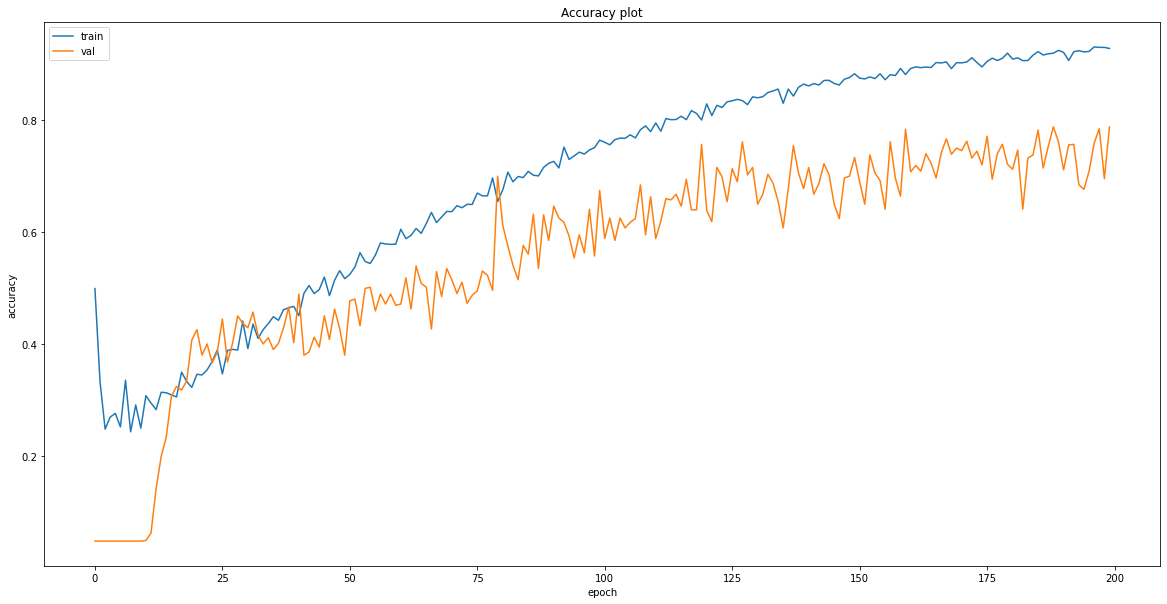

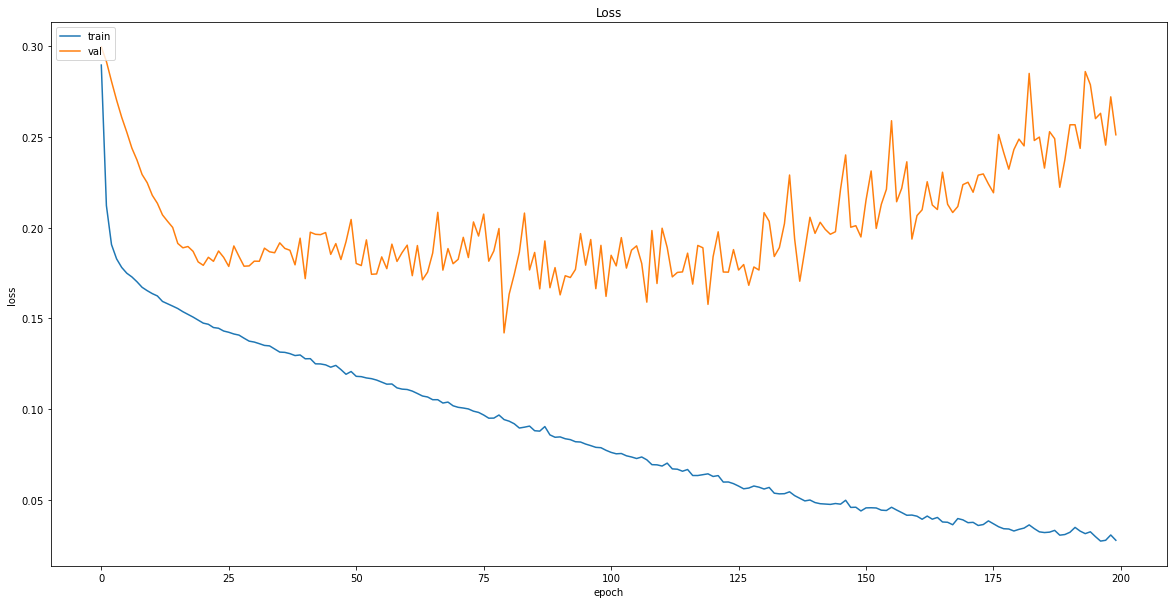

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
# Save model
model.save("models/{}".format('bear_time_series_lstm_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/bear_time_series_lstm_buy_hold_sell.model\assets


### Test Performance

### Accumulation Phase Test Data

In [21]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [22]:
seed = 10
df = pd.read_csv("accumulation phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2004-06-14    93.010002  92.918784 -32.009897  48922600.0     2.0
2004-06-15    91.529999  92.705124 -68.734488  45879300.0     2.0
2004-06-16    90.209999  92.321259 -94.676024  40369000.0     2.0
2004-06-17    89.980003  91.961066 -87.983635  36219100.0     2.0
2004-06-18    89.339996  91.557824 -85.961924  32718400.0     2.0


In [23]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [24]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(248, 15, 4)

In [25]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [26]:
model = tf.keras.models.load_model("models/bear_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

8/8 [==============================] - 0s 3ms/step - loss: 0.2106 - accuracy: 0.7984 - mean_squared_error: 8.5817 - weighted_accuracy: 0.7984 - weighted_mean_squared_error: 8.5817
Test loss: 0.2106045037508011
Test accuracy: 0.7983871102333069


In [27]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 214, 1: 12, 0: 22})

In [28]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 229, 1: 11, 0: 8})

In [29]:
df = pd.read_csv("accumulation phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [30]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2004-07-01,93.650002,92.599542,-13.252981,56757300.0,2.0,2,2
2004-07-02,93.610001,92.761151,-20.080318,52187800.0,2.0,1,2
2004-07-06,92.199997,92.891743,-20.615805,48857200.0,2.0,1,2
2004-07-07,90.570000,92.785321,-39.491353,46253500.0,2.0,2,2
2004-07-08,90.000000,92.444502,-61.311929,41751600.0,2.0,2,2


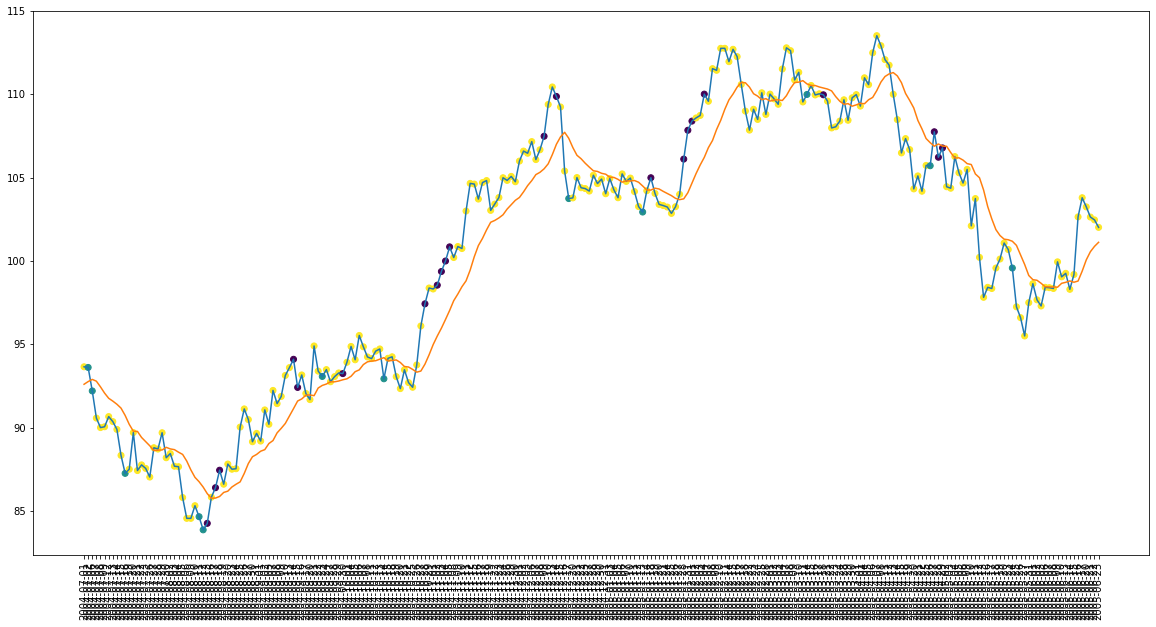

In [31]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [32]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 248
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 10
actual holds but predicted sell: 22
actual predicted holds: 197
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 0.0%
Percentage holds correct: 86.02620087336244%
actual buys: 11
actual sells: 8
actual holds: 229


In [33]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[89.88999938964844, 90.0, 90.05000305175781, 90.36000061035156, 90.56999969482422, 90.66000366210938, 92.1999969482422, 93.61000061035156, 93.6500015258789]
[87.25, 87.41999816894531, 87.5, 87.76000213623047, 88.33000183105469, 89.69999694824219, 89.88999938964844, 90.36000061035156, 90.66000366210938]
Percentage buys correct: 50.0%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 84.57943925233644%


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[89.88999938964844, 90.0, 90.05000305175781, 90.36000061035156, 90.56999969482422, 90.66000366210938, 92.1999969482422, 93.61000061035156, 93.6500015258789]
[87.25, 87.41999816894531, 87.5, 87.76000213623047, 88.33000183105469, 89.69999694824219, 89.88999938964844, 90.36000061035156, 90.66000366210938]
Percentage buys correct: 50.0%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 84.57943925233644%


In [35]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $93.61000061035156
Shares owned at the moment: 106
Cash capital at the moment: $50.0526201248158


Stop Loss Activated!

Share price: $90.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9624.071432865141


Share price: $87.25
Shares owned at the moment: 110
Cash capital at the moment: $0.17830786514059582


Stop Loss Activated!

Share price: $84.55000305175781
Shares owned at the moment: 0
Cash capital at the moment: $9275.102267635342


Share price: $84.6500015258789
Shares owned at the moment: 109
Cash capital at the moment: $22.878263357159085


Price increase from previously bought: 10.858749517266975%
Share price: $94.0999984741211
Shares owned at the moment: 0
Cash capital at the moment: $10251.57162249374


Share price: $93.06999969482422
Shares owned at the moment: 109
Cash capital at the moment: $79.0439233493762


Price increase from previously bought: 5.597651344268462%
Share price: $98.5500030517578
Shares owned at the moment: 0
Cash c

In [36]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10830.181677955627
profit gained: 8.301816779556265%


In [37]:
logger

[0.7983871102333069,
 '9.090909090909092%',
 '0.0%',
 '86.02620087336244%',
 '50.0%',
 '45.45454545454545%',
 '84.57943925233644%',
 '1.5361694488524336%',
 '8.301816779556265%']

In [38]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.798387,9.090909090909092%,0.0%,86.02620087336244%,50.0%,45.45454545454545%,84.57943925233644%,1.5361694488524336%,8.301816779556265%


### Mark Up Phase Test Data

In [39]:
logger = []

In [40]:
seed = 10
df = pd.read_csv("mark up phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


In [41]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [42]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(219, 15, 4)

In [43]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [44]:
model = tf.keras.models.load_model("models/bear_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1743 - accuracy: 0.8539 - mean_squared_error: 10.4427 - weighted_accuracy: 0.8539 - weighted_mean_squared_error: 10.4427
Test loss: 0.17433668673038483
Test accuracy: 0.853881299495697


In [45]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 198, 1: 14, 0: 7})

In [46]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [47]:
df = pd.read_csv("mark up phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [48]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-10,115.250000,115.943088,-17.142986,-11228200.0,2.0,2,2
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,0


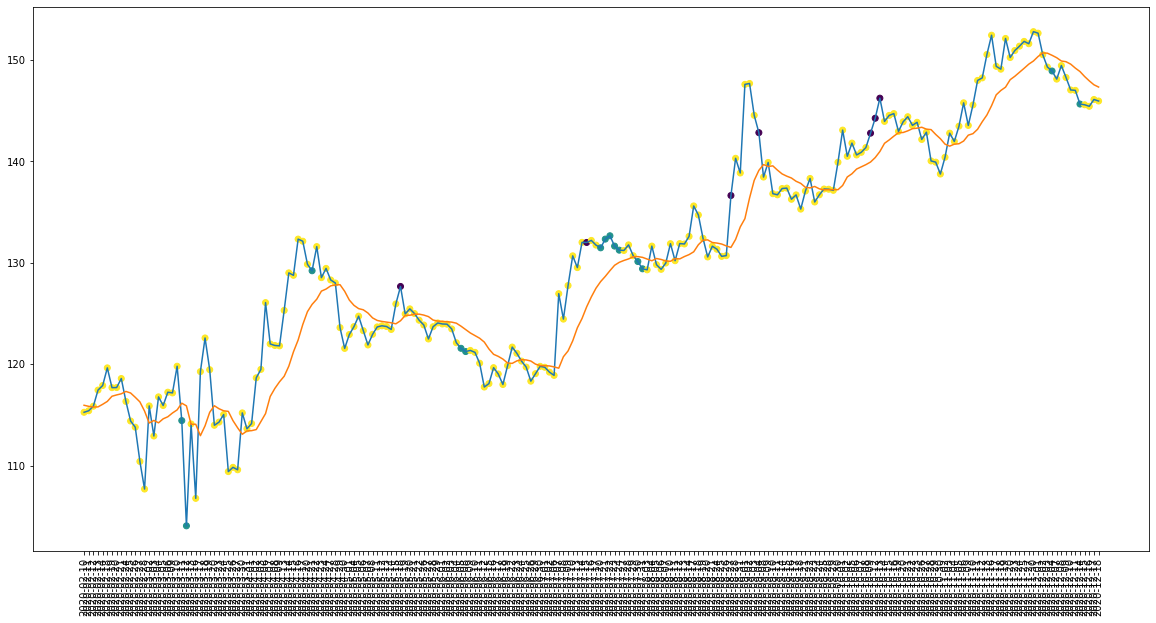

In [49]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [50]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))
logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 11
actual holds but predicted sell: 6
actual predicted holds: 184
Percentage buys correct: 28.571428571428573%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 91.54228855721394%
actual buys: 7
actual sells: 11
actual holds: 201


In [51]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[115.25, 115.4000015258789, 115.8499984741211, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.68000030517578, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 71.42857142857143%
Percentage sells correct: 71.42857142857143%
Percentage holds correct: 85.35353535353535%


In [52]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $114.43000030517578
Shares owned at the moment: 87
Cash capital at the moment: $17.21259587669374


Stop Loss Activated!

Share price: $104.0500030517578
Shares owned at the moment: 0
Cash capital at the moment: $9044.668898149488


Share price: $104.0500030517578
Shares owned at the moment: 86
Cash capital at the moment: $71.76080997657664


Price increase from previously bought: 22.354538874775564%
Share price: $127.66000366210938
Shares owned at the moment: 0
Cash capital at the moment: $11020.329534051894


Share price: $121.55999755859376
Shares owned at the moment: 90
Cash capital at the moment: $49.84365438270288


Stop Loss Activated!

Share price: $117.73999786376952
Shares owned at the moment: 0
Cash capital at the moment: $10617.302812650676


Share price: $131.47000122070312
Shares owned at the moment: 80
Cash capital at the moment: $70.77931472587079


Price increase from previously bought: 8.34281219524804%
Share price: $142.8300018310547
Shares owned at the 

In [53]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12578.425938270568
profit gained: 25.784259382705677%


In [54]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.798387,9.090909090909092%,0.0%,86.02620087336244%,50.0%,45.45454545454545%,84.57943925233644%,1.5361694488524336%,8.301816779556265%
1,0.853881,28.571428571428573%,9.090909090909092%,91.54228855721394%,71.42857142857143%,71.42857142857143%,85.35353535353535%,11.79170610425941%,25.784259382705677%


### Distribution Phase Test Data

In [55]:
logger = []

In [56]:
seed = 10
df = pd.read_csv("distribution phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2016-12-05   223.360001  213.378658 -16.514565 -283274800.0     2.0
2016-12-06   228.550003  215.712711  -2.667189 -278675500.0     2.0
2016-12-07   231.380005  218.123064  -4.633597 -273416200.0     2.0
2016-12-08   235.559998  220.805669  -1.742271 -266821000.0     2.0
2016-12-09   241.449997  223.981719  -2.918174 -259477300.0     2.0


In [57]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [58]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(470, 15, 4)

In [59]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [60]:
model = tf.keras.models.load_model("models/bear_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

15/15 [==============================] - 0s 3ms/step - loss: 0.1646 - accuracy: 0.8404 - mean_squared_error: 9.4891 - weighted_accuracy: 0.8404 - weighted_mean_squared_error: 9.4891
Test loss: 0.1646088808774948
Test accuracy: 0.8404255509376526


In [61]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 430, 1: 28, 0: 12})

In [62]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 426, 1: 24, 0: 20})

In [63]:
df = pd.read_csv("distribution phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [64]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2016-12-23,240.970001,237.434924,-26.807731,-247920400.0,2.0,2,2
2016-12-27,241.559998,237.978782,-26.032839,-245732900.0,2.0,2,2
2016-12-28,240.649994,238.529738,-26.433792,-243734700.0,2.0,2,2
2016-12-29,238.179993,238.855931,-48.235368,-246787700.0,1.0,1,1
2016-12-30,239.449997,238.751941,-72.451037,-249406700.0,2.0,2,2


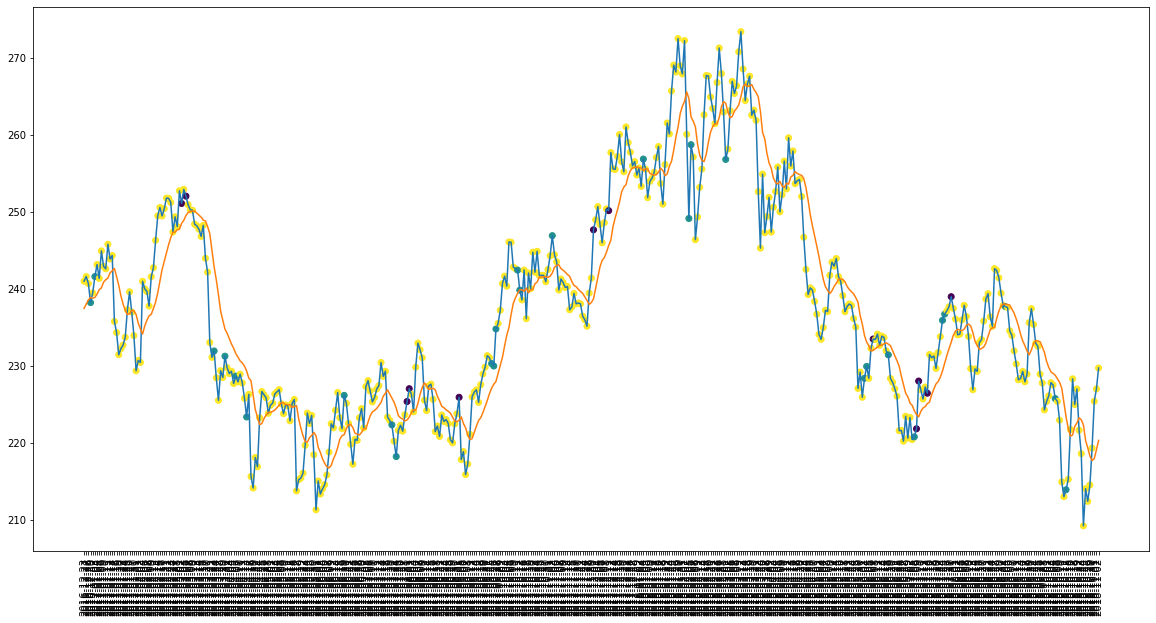

In [65]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

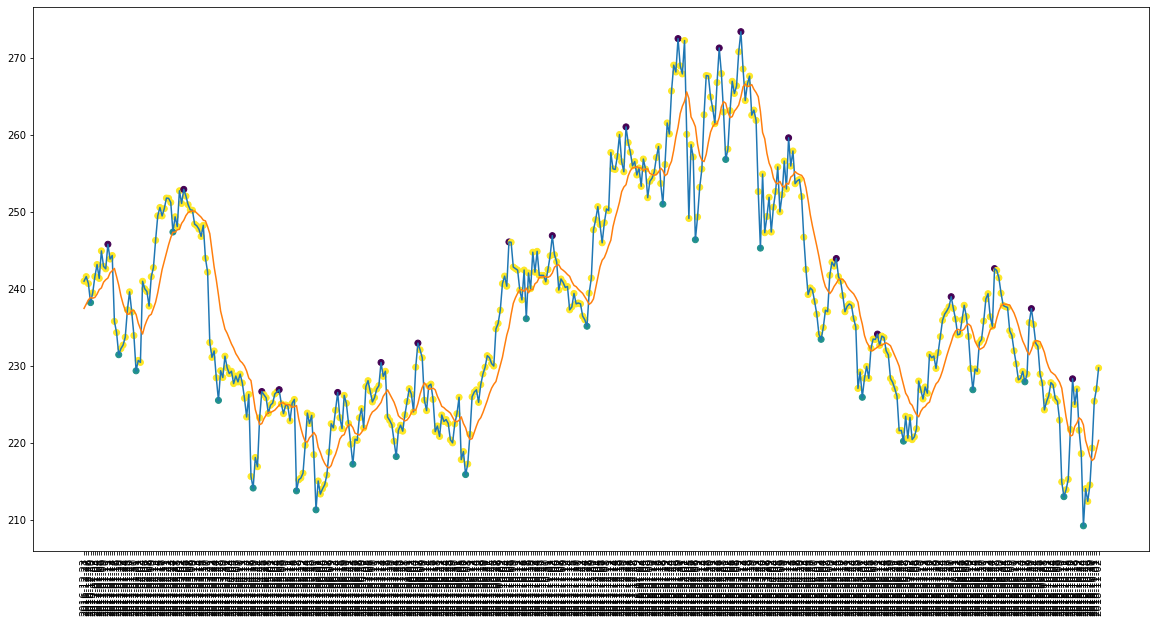

In [66]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [67]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 470
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 21
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 18
actual holds but predicted buy: 24
actual holds but predicted sell: 11
actual predicted holds: 391
Percentage buys correct: 12.5%
Percentage sells correct: 5.0%
Percentage holds correct: 91.78403755868544%
actual buys: 24
actual sells: 20
actual holds: 426


In [68]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[238.17999267578125, 239.4499969482422, 240.6499938964844, 240.97000122070312, 241.32000732421875, 241.55999755859366, 241.57000732421875, 243.1300048828125, 244.8999938964844]
[235.7400054931641, 241.32000732421875, 242.57000732421875, 242.88999938964844, 243.1300048828125, 243.83999633789062, 244.3000030517578, 244.8999938964844, 245.75999450683602]
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 75.0%
Percentage holds correct: 85.54778554778555%


In [69]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $238.17999267578125
Shares owned at the moment: 41
Cash capital at the moment: $207.76550611877428


Stop Loss Activated!

Share price: $231.41000366210938
Shares owned at the moment: 0
Cash capital at the moment: $9669.484178352355


Share price: $231.8999938964844
Shares owned at the moment: 41
Cash capital at the moment: $135.4377042846645


Stop Loss Activated!

Share price: $225.47999572753903
Shares owned at the moment: 0
Cash capital at the moment: $9354.694659595483


Share price: $231.22000122070312
Shares owned at the moment: 40
Cash capital at the moment: $80.46041063308076


Stop Loss Activated!

Share price: $223.32000732421875
Shares owned at the moment: 0
Cash capital at the moment: $8988.695502796167


Share price: $223.32000732421875
Shares owned at the moment: 40
Cash capital at the moment: $31.33000902175263


Stop Loss Activated!

Share price: $215.58999633789062
Shares owned at the moment: 0
Cash capital at the moment: $8631.21496294021


Share price: 

In [70]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9484.453134635925
profit gained: -5.155468653640746%


In [71]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.798387,9.090909090909092%,0.0%,86.02620087336244%,50.0%,45.45454545454545%,84.57943925233644%,1.5361694488524336%,8.301816779556265%
1,0.853881,28.571428571428573%,9.090909090909092%,91.54228855721394%,71.42857142857143%,71.42857142857143%,85.35353535353535%,11.79170610425941%,25.784259382705677%
2,0.840426,12.5%,5.0%,91.78403755868544%,42.857142857142854%,75.0%,85.54778554778555%,-19.700492934074553%,-5.155468653640746%


### Mark Down Phase Test Data

In [72]:
logger = []

In [73]:
seed = 10
df = pd.read_csv("mark down phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2007-10-01   216.740005  205.638670  -5.220429  161688200.0     2.0
2007-10-02   222.979996  208.306567  -1.526716  171593800.0     2.0
2007-10-03   228.020004  211.339403  -1.071898  181013600.0     2.0
2007-10-04   227.350006  213.802573  -7.282412  170892200.0     2.0
2007-10-05   225.949997  215.671407 -10.566735  160852300.0     2.0


In [74]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [75]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(278, 15, 4)

In [76]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [77]:
model = tf.keras.models.load_model("models/bear_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

9/9 [==============================] - 0s 3ms/step - loss: 0.2292 - accuracy: 0.8201 - mean_squared_error: 10.6035 - weighted_accuracy: 0.8201 - weighted_mean_squared_error: 10.6035
Test loss: 0.22916848957538605
Test accuracy: 0.8201438784599304


In [78]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 251, 0: 11, 1: 16})

In [79]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({1: 16, 2: 249, 0: 13})

In [80]:
df = pd.read_csv("mark down phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [81]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2007-10-19,217.690002,226.848008,-48.765388,164382100.0,1.0,2,1
2007-10-22,222.179993,225.439084,-99.592777,151275300.0,2.0,2,2
2007-10-23,223.759995,224.937685,-65.618001,163438800.0,2.0,2,2
2007-10-24,225.119995,224.756502,-59.700390,171615400.0,2.0,2,2
2007-10-25,226.660004,224.812424,-54.606755,184266200.0,2.0,2,2


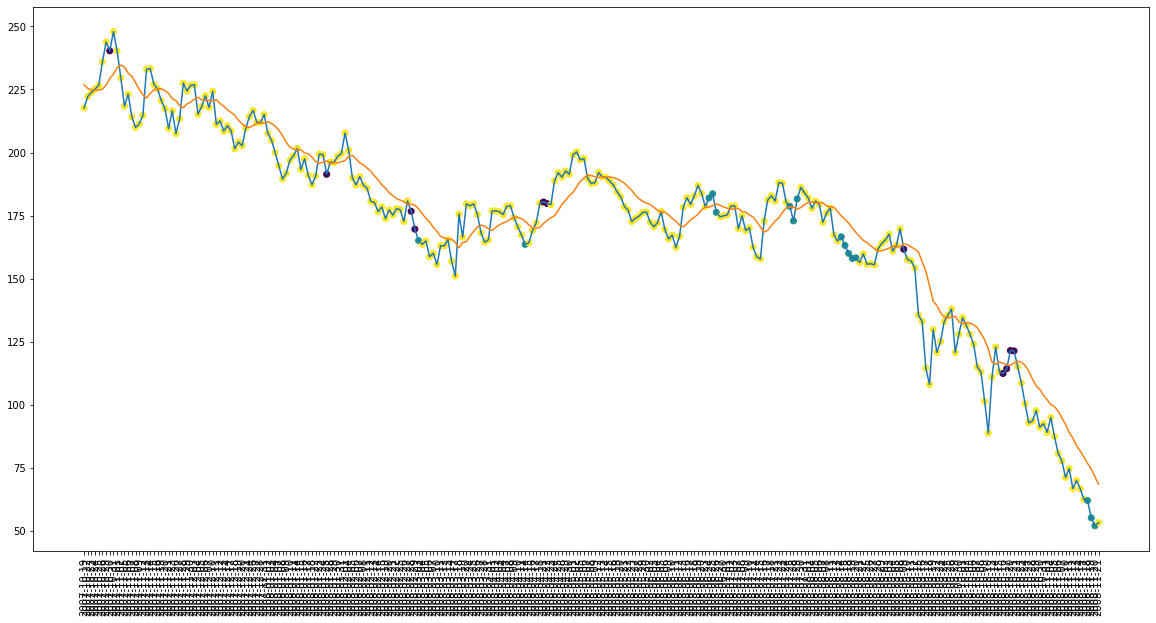

In [82]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

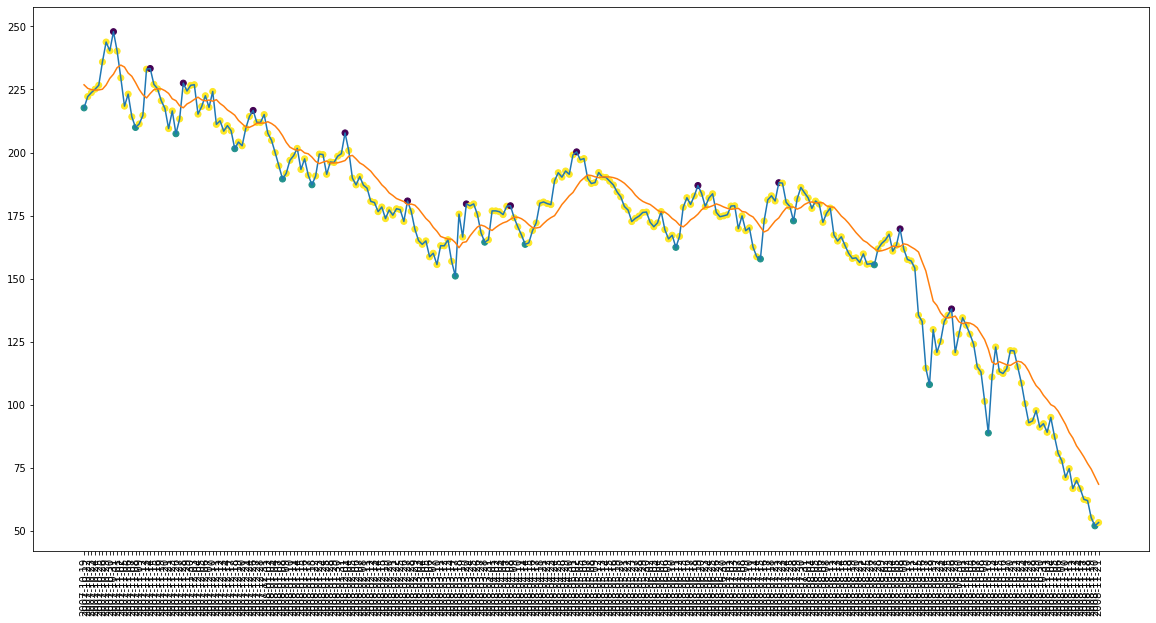

In [83]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [84]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 278
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 13
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 13
actual holds but predicted buy: 13
actual holds but predicted sell: 11
actual predicted holds: 225
Percentage buys correct: 18.75%
Percentage sells correct: 0.0%
Percentage holds correct: 90.36144578313252%
actual buys: 16
actual sells: 13
actual holds: 249


In [85]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[217.69000244140625, 222.17999267578125, 223.75999450683602, 225.1199951171875, 226.66000366210938, 235.9199981689453, 240.3300018310547, 243.80999755859366, 247.9199981689453]
[209.94000244140625, 214.17999267578125, 218.38999938964844, 223.16000366210938, 229.6000061035156, 240.2100067138672, 240.3300018310547, 243.80999755859366, 247.9199981689453]
Percentage buys correct: 50.0%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 82.8%


In [86]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $165.0800018310547
Shares owned at the moment: 60
Cash capital at the moment: $67.96168983459393


Stop Loss Activated!

Share price: $158.64999389648438
Shares owned at the moment: 0
Cash capital at the moment: $9560.784074630736


Share price: $163.58999633789062
Shares owned at the moment: 58
Cash capital at the moment: $46.47168261718616


Price increase from previously bought: 9.97326149159299%
Share price: $180.3999938964844
Shares owned at the moment: 0
Cash capital at the moment: $10480.897529586791


Share price: $181.97999572753903
Shares owned at the moment: 57
Cash capital at the moment: $79.51240878677527


Stop Loss Activated!

Share price: $176.25999450683594
Shares owned at the moment: 0
Cash capital at the moment: $10098.703341537477


Share price: $176.25999450683594
Shares owned at the moment: 57
Cash capital at the moment: $24.2549005088822


Stop Loss Activated!

Share price: $169.82000732421875
Shares owned at the moment: 0
Cash capital at the moment:

In [87]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $2569.3637014627457
profit gained: -74.30636298537254%


In [88]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.798387,9.090909090909092%,0.0%,86.02620087336244%,50.0%,45.45454545454545%,84.57943925233644%,1.5361694488524336%,8.301816779556265%
1,0.853881,28.571428571428573%,9.090909090909092%,91.54228855721394%,71.42857142857143%,71.42857142857143%,85.35353535353535%,11.79170610425941%,25.784259382705677%
2,0.840426,12.5%,5.0%,91.78403755868544%,42.857142857142854%,75.0%,85.54778554778555%,-19.700492934074553%,-5.155468653640746%
3,0.820144,18.75%,0.0%,90.36144578313252%,50.0%,54.54545454545455%,82.8%,-29.935916939115586%,-74.30636298537254%


### bull phase test data

In [89]:
logger = []

In [90]:
seed = 10
df = pd.read_csv("bull phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


In [91]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(208, 15, 4)

In [92]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [93]:
model = tf.keras.models.load_model("models/bear_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1768 - accuracy: 0.7837 - mean_squared_error: 8.8663 - weighted_accuracy: 0.7837 - weighted_mean_squared_error: 8.8663
Test loss: 0.17681676149368286
Test accuracy: 0.7836538553237915


In [94]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 171, 1: 9, 0: 28})

In [95]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [96]:
df = pd.read_csv("bull phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [97]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


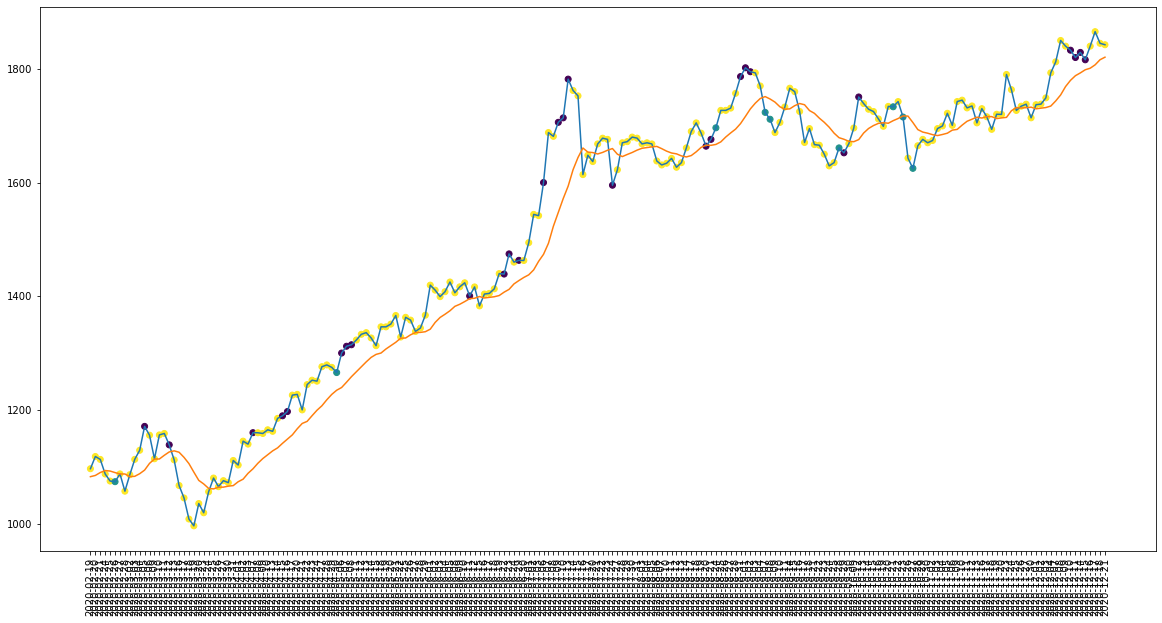

In [98]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

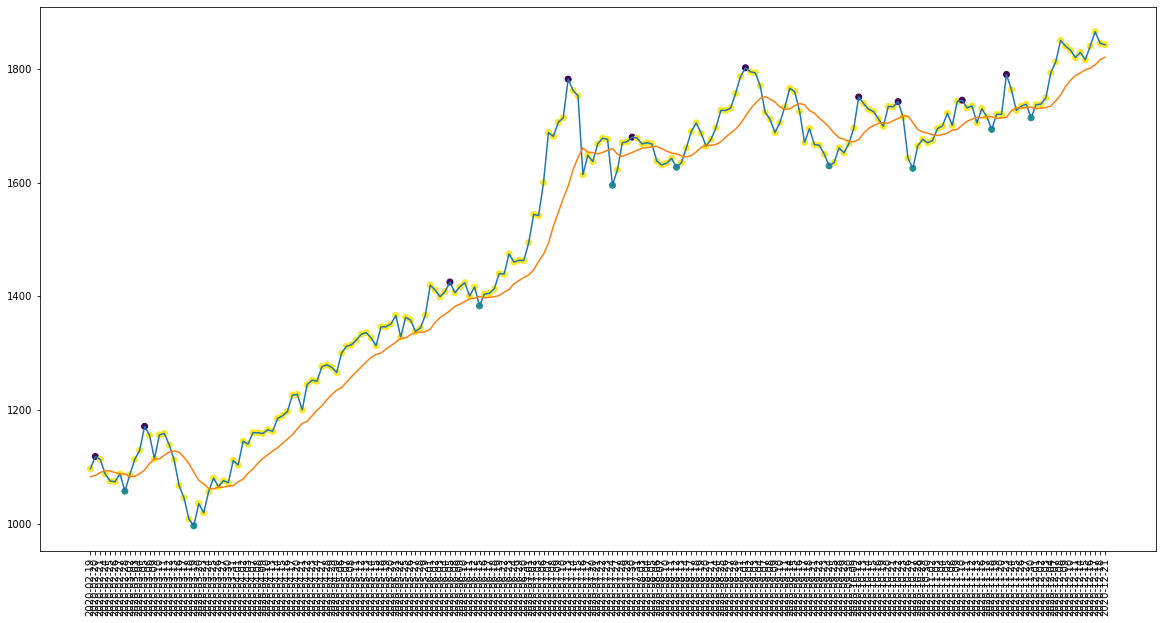

In [99]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [100]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 8
actual holds but predicted sell: 23
actual predicted holds: 158
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 40.0%
Percentage holds correct: 83.5978835978836%
actual buys: 9
actual sells: 10
actual holds: 189


In [101]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 39.285714285714285%
Percentage holds correct: 85.88235294117646%


In [102]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1073.699951171875
Shares owned at the moment: 9
Cash capital at the moment: $310.1263656616211


Price increase from previously bought: 8.763028267495043%
Share price: $1171.0
Shares owned at the moment: 0
Cash capital at the moment: $10820.14411566162


Share price: $1265.699951171875
Shares owned at the moment: 8
Cash capital at the moment: $666.6991073608388


Price increase from previously bought: 10.343628968696006%
Share price: $1400.4599609375
Shares owned at the moment: 0
Cash capital at the moment: $11839.568675720213


Share price: $1696.3499755859375
Shares owned at the moment: 6
Cash capital at the moment: $1633.4790476074195


Price increase from previously bought: 5.025532702303437%
Share price: $1786.5
Shares owned at the moment: 0
Cash capital at the moment: $12323.00179760742


Share price: $1723.5
Shares owned at the moment: 7
Cash capital at the moment: $225.32442260741846


Stop Loss Activated!

Share price: $1670.52001953125
Shares owned at the moment

In [103]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


In [104]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.798387,9.090909090909092%,0.0%,86.02620087336244%,50.0%,45.45454545454545%,84.57943925233644%,1.5361694488524336%,8.301816779556265%
1,0.853881,28.571428571428573%,9.090909090909092%,91.54228855721394%,71.42857142857143%,71.42857142857143%,85.35353535353535%,11.79170610425941%,25.784259382705677%
2,0.840426,12.5%,5.0%,91.78403755868544%,42.857142857142854%,75.0%,85.54778554778555%,-19.700492934074553%,-5.155468653640746%
3,0.820144,18.75%,0.0%,90.36144578313252%,50.0%,54.54545454545455%,82.8%,-29.935916939115586%,-74.30636298537254%
4,0.783654,11.11111111111111%,40.0%,83.5978835978836%,66.66666666666667%,39.285714285714285%,85.88235294117646%,31.398350055847114%,66.41259749999998%


### bear phase test data

In [105]:
logger = []

In [106]:
seed = 10
df = pd.read_csv("bear phase data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-01-22    32.830002  32.653718 -49.494874  128764966.0     2.0
2018-01-23    33.750000  32.822377 -18.518497  165063463.0     2.0
2018-01-24    33.970001  32.998934 -16.190425  201240854.0     2.0
2018-01-25    33.959999  33.146790 -17.627141  173336178.0     2.0
2018-01-26    34.880001  33.413438  -2.648942  221767625.0     0.0


In [107]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(595, 15, 4)

In [108]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [109]:
model = tf.keras.models.load_model("models/bear_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

19/19 [==============================] - 0s 3ms/step - loss: 0.2267 - accuracy: 0.7798 - mean_squared_error: 10.0772 - weighted_accuracy: 0.7798 - weighted_mean_squared_error: 10.0772
Test loss: 0.22670914232730865
Test accuracy: 0.7798319458961487


In [110]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 500, 1: 42, 0: 53})

In [111]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [112]:
df = pd.read_csv("bear phase data/test_data.csv")
df.set_index('Date', inplace=True)

In [113]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2018-02-09,32.009998,33.951521,-90.236635,104835489.0,1.0,2,1
2018-02-12,32.320000,33.652826,-74.280269,68354718.0,2.0,2,2
2018-02-13,32.919998,33.447775,-68.330148,85359125.0,2.0,2,2
2018-02-14,33.209999,33.366579,-56.813864,101567392.0,2.0,2,2
2018-02-22,34.020000,33.342490,-51.247629,113719002.0,2.0,2,2


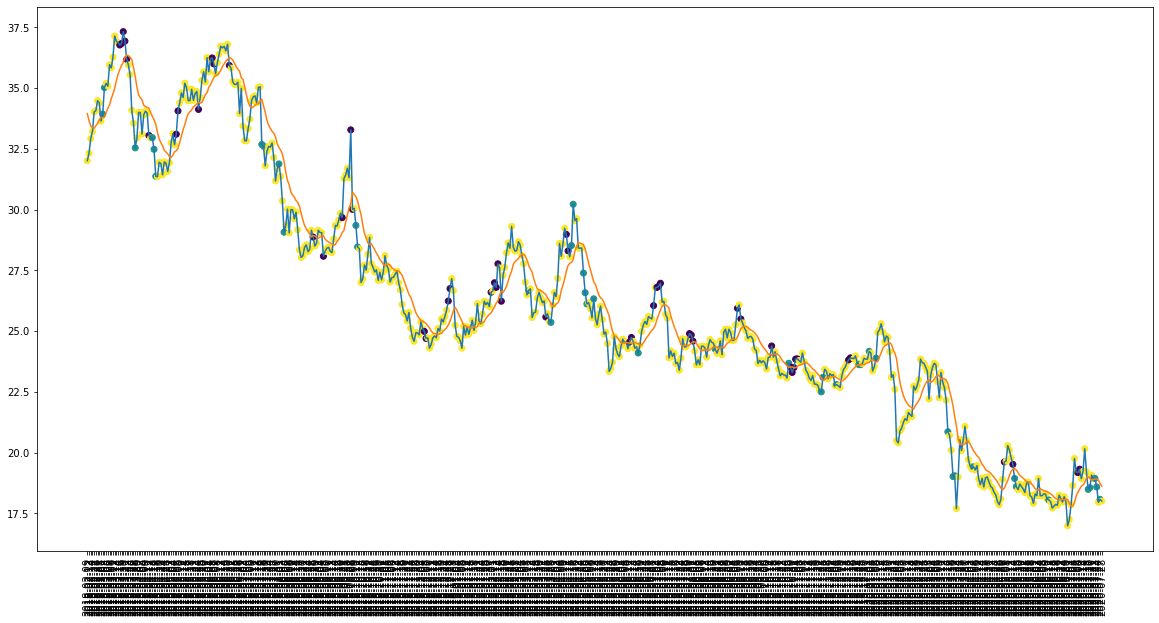

In [114]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

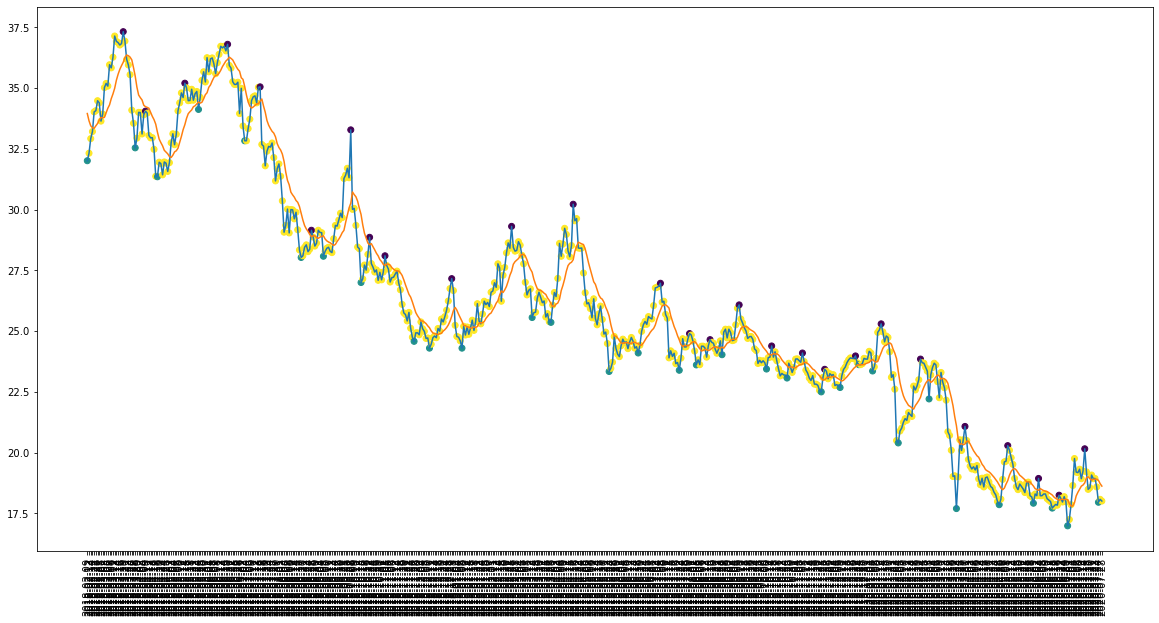

In [115]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [116]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 595
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 25
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 21
actual holds but predicted buy: 36
actual holds but predicted sell: 46
actual predicted holds: 454
Percentage buys correct: 15.625%
Percentage sells correct: 18.51851851851852%
Percentage holds correct: 84.70149253731343%
actual buys: 32
actual sells: 27
actual holds: 536


In [117]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[32.009998321533196, 32.31999969482422, 32.919998168945305, 33.209999084472656, 33.639999389648445, 34.02000045776367, 34.06999969482422, 34.389999389648445, 34.47999954223633]
[33.639999389648445, 33.93000030517578, 34.389999389648445, 34.47999954223633, 35.02000045776367, 35.080001831054695, 35.189998626708984, 35.83000183105469, 35.959999084472656]
Percentage buys correct: 47.61904761904762%
Percentage sells correct: 50.943396226415096%
Percentage holds correct: 83.96793587174349%


In [118]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $33.93000030517578
Shares owned at the moment: 293
Cash capital at the moment: $31.17081283760126


Price increase from previously bought: 8.072973584488041%
Share price: $36.77000045776367
Shares owned at the moment: 0
Cash capital at the moment: $10775.153519093514


Share price: $32.540000915527344
Shares owned at the moment: 330
Cash capital at the moment: $7.4231661386493215


Stop Loss Activated!

Share price: $31.3700008392334
Shares owned at the moment: 0
Cash capital at the moment: $10331.055167324066


Share price: $31.3700008392334
Shares owned at the moment: 328
Cash capital at the moment: $13.399151298523066


Price increase from previously bought: 5.225445417532493%
Share price: $33.09999847412109
Shares owned at the moment: 0
Cash capital at the moment: $10840.342452186582


Share price: $32.68000030517578
Shares owned at the moment: 330
Cash capital at the moment: $26.285251201627034


Stop Loss Activated!

Share price: $31.18000030517578
Shares owned at th

In [119]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5603.220989425184
profit gained: -43.967790105748165%


In [120]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.798387,9.090909090909092%,0.0%,86.02620087336244%,50.0%,45.45454545454545%,84.57943925233644%,1.5361694488524336%,8.301816779556265%
1,0.853881,28.571428571428573%,9.090909090909092%,91.54228855721394%,71.42857142857143%,71.42857142857143%,85.35353535353535%,11.79170610425941%,25.784259382705677%
2,0.840426,12.5%,5.0%,91.78403755868544%,42.857142857142854%,75.0%,85.54778554778555%,-19.700492934074553%,-5.155468653640746%
3,0.820144,18.75%,0.0%,90.36144578313252%,50.0%,54.54545454545455%,82.8%,-29.935916939115586%,-74.30636298537254%
4,0.783654,11.11111111111111%,40.0%,83.5978835978836%,66.66666666666667%,39.285714285714285%,85.88235294117646%,31.398350055847114%,66.41259749999998%


### Full Cycle Test Data

In [121]:
logger = []

In [122]:
seed = 10
df = pd.read_csv("full cycle data/test_data.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2002-11-11         8.74  8.763110 -71.929852 -553467352.0     2.0
2002-11-12         8.50  8.722632 -80.487816 -559735252.0     2.0
2002-11-13         8.63  8.708381 -69.918697 -552295352.0     2.0
2002-11-14         8.52  8.679399 -78.861762 -566378552.0     2.0
2002-11-15         8.80  8.697953 -56.097548 -558353452.0     2.0


In [123]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(917, 15, 4)

In [124]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [125]:
model = tf.keras.models.load_model("models/bear_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
logger.append(score[1])

29/29 [==============================] - 0s 3ms/step - loss: 0.1961 - accuracy: 0.8103 - mean_squared_error: 10.4564 - weighted_accuracy: 0.8103 - weighted_mean_squared_error: 10.4564
Test loss: 0.19607184827327728
Test accuracy: 0.8102508187294006


In [126]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 805, 0: 59, 1: 53})

In [127]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [128]:
df = pd.read_csv("full cycle data/test_data.csv")
df.set_index('Date', inplace=True)

In [129]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2002-12-02,11.45,10.087284,-3.883491,-531653852.0,0.0,2,0
2002-12-03,9.96,10.296932,-13.142858,-519461852.0,2.0,0,2
2002-12-04,10.15,10.245097,-55.714280,-548693152.0,2.0,2,2
2002-12-05,10.02,10.230466,-51.764718,-529235552.0,2.0,1,2
2002-12-06,9.88,10.198087,-55.588224,-540995752.0,2.0,1,2


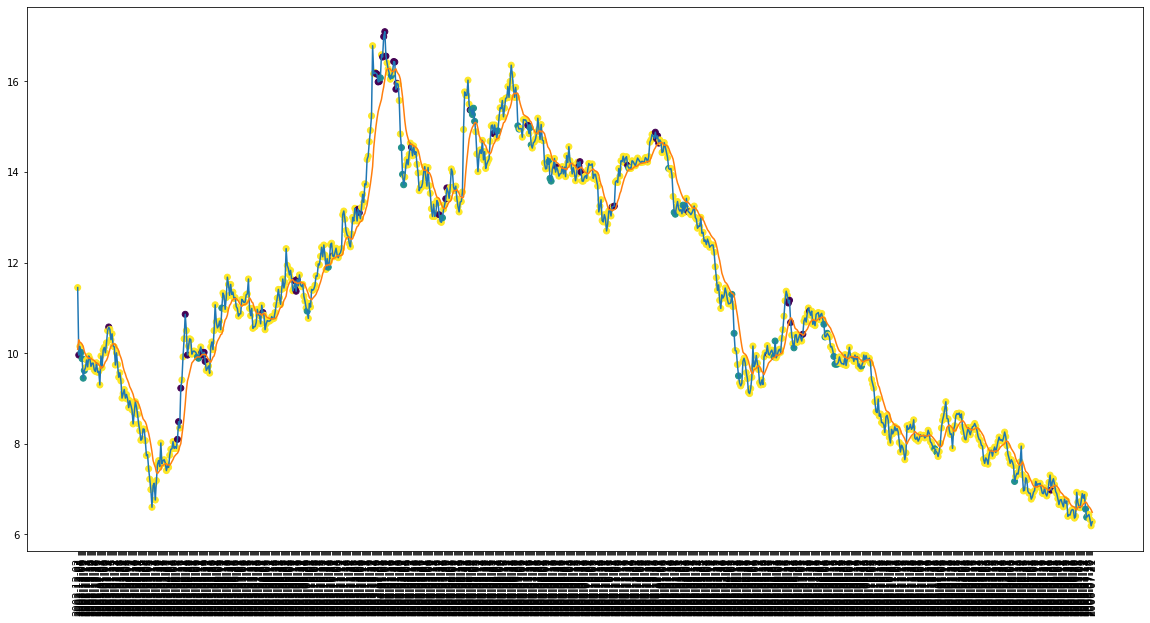

In [130]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

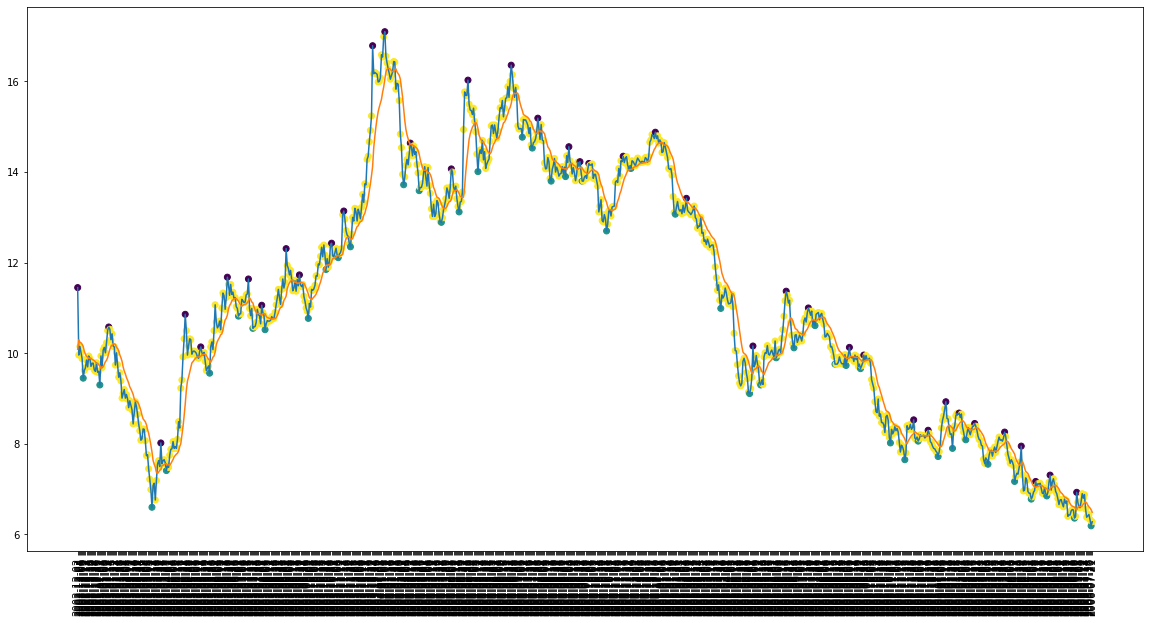

In [131]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [132]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

logger.append(str(100*buy_buy/buy) + "%")
logger.append(str(100*sell_sell/sell) + "%")
logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 917
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 39
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 35
actual holds but predicted buy: 46
actual holds but predicted sell: 54
actual predicted holds: 731
Percentage buys correct: 15.217391304347826%
Percentage sells correct: 12.5%
Percentage holds correct: 87.96630565583634%
actual buys: 46
actual sells: 40
actual holds: 831


In [133]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

logger.append(str(100*correct_minima/buy) + "%")
logger.append(str(100*correct_maxima/sell) + "%")
logger.append(str(100*correct_hold/hold) + "%")

[9.449999809265137, 9.619999885559082, 9.68000030517578, 9.850000381469727, 9.880000114440918, 9.960000038146973, 10.020000457763672, 10.149999618530273, 11.449999809265135]
[9.619999885559082, 9.68000030517578, 9.699999809265137, 9.710000038146973, 9.779999732971193, 9.779999732971193, 9.850000381469727, 9.880000114440918, 9.9399995803833]
Percentage buys correct: 62.264150943396224%
Percentage sells correct: 45.76271186440678%
Percentage holds correct: 84.82587064676616%


In [134]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.020000457763672
Shares owned at the moment: 995
Cash capital at the moment: $2.6823182725911465


Stop Loss Activated!

Share price: $9.449999809265137
Shares owned at the moment: 0
Cash capital at the moment: $9379.5745665133


Share price: $9.449999809265137
Shares owned at the moment: 989
Cash capital at the moment: $7.823118168829751


Price increase from previously bought: 11.650634166078945%
Share price: $10.579999923706056
Shares owned at the moment: 0
Cash capital at the moment: $10442.66808792162


Share price: $9.920000076293944
Shares owned at the moment: 1049
Cash capital at the moment: $7.971287669184676


Stop Loss Activated!

Share price: $9.619999885559082
Shares owned at the moment: 0
Cash capital at the moment: $10071.599872950796


Share price: $11.0
Shares owned at the moment: 913
Cash capital at the moment: $0.9816229507960088


Stop Loss Activated!

Share price: $10.550000190734863
Shares owned at the moment: 0
Cash capital at the moment: $9606.64

In [135]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')
logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5459.681323426963
profit gained: -45.40318676573037%


In [136]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.798387,9.090909090909092%,0.0%,86.02620087336244%,50.0%,45.45454545454545%,84.57943925233644%,1.5361694488524336%,8.301816779556265%
1,0.853881,28.571428571428573%,9.090909090909092%,91.54228855721394%,71.42857142857143%,71.42857142857143%,85.35353535353535%,11.79170610425941%,25.784259382705677%
2,0.840426,12.5%,5.0%,91.78403755868544%,42.857142857142854%,75.0%,85.54778554778555%,-19.700492934074553%,-5.155468653640746%
3,0.820144,18.75%,0.0%,90.36144578313252%,50.0%,54.54545454545455%,82.8%,-29.935916939115586%,-74.30636298537254%
4,0.783654,11.11111111111111%,40.0%,83.5978835978836%,66.66666666666667%,39.285714285714285%,85.88235294117646%,31.398350055847114%,66.41259749999998%
5,0.779832,15.625%,18.51851851851852%,84.70149253731343%,47.61904761904762%,50.943396226415096%,83.96793587174349%,-36.630252912736076%,-43.967790105748165%
6,0.810251,15.217391304347826%,12.5%,87.96630565583634%,62.264150943396224%,45.76271186440678%,84.82587064676616%,-27.357899121768583%,-45.40318676573037%


In [137]:
experiment

'Bear Phase LSTM Time Series'

In [138]:
if not os.path.exists('{}.csv'.format(experiment)):
            log.to_csv('{}.csv'.format(experiment))